Imports

In [30]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit_ibm_provider import IBMProvider
import numpy as np


Quantum Teleportation Protocol

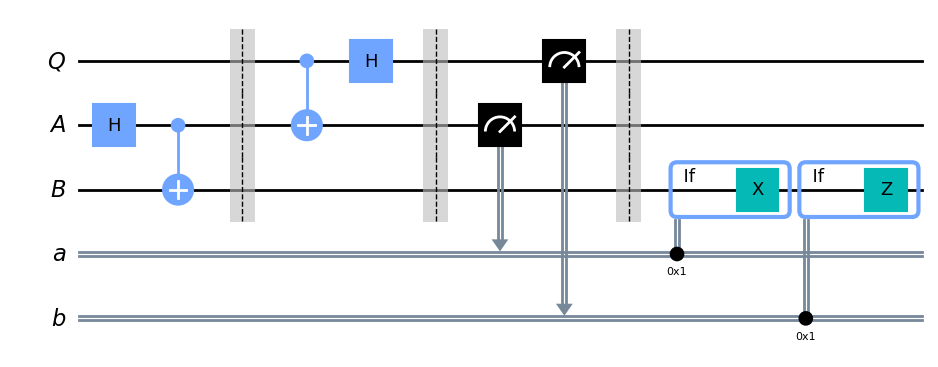

In [31]:
# Set up registers and circuit
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw("mpl"))

Generate random unitary gate

In [32]:
random_gate = UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi,
)

display(random_gate.to_matrix())

array([[ 0.45778141+0.j        ,  0.86828935-0.19107537j],
       [-0.15715126+0.87506552j, -0.01780928-0.45743485j]])

Test circuit applying random gate to Q

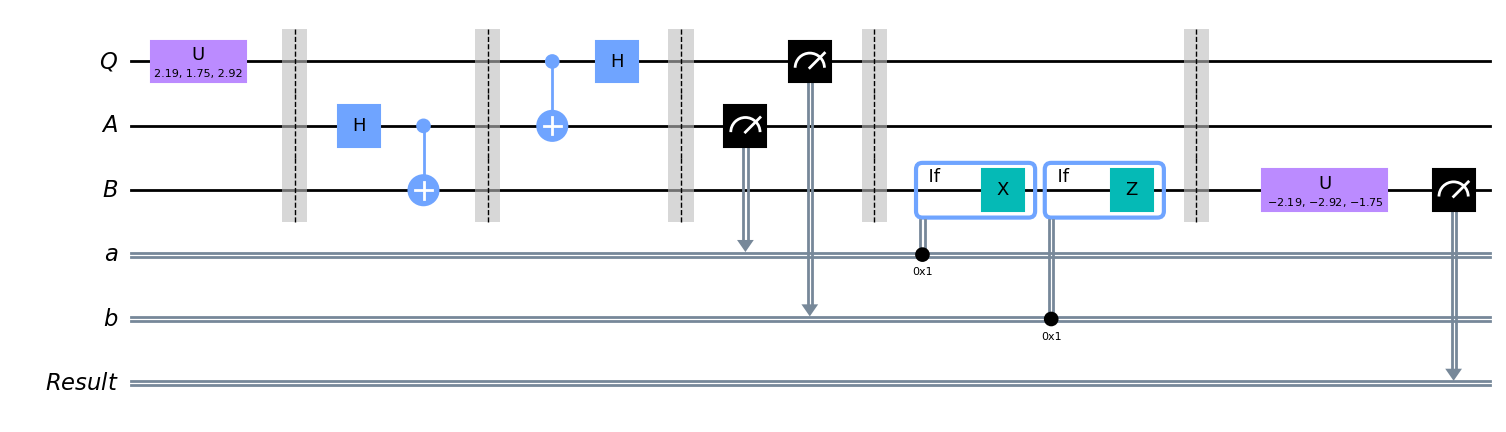

In [33]:
# Create a new circuit including the same bits and qubits
# used in the teleportation protocol

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# apply the random gate to Q
test.append(random_gate, qubit)
test.barrier()

# append the teleportation protocol
test = test.compose(protocol)
test.barrier()

# apply the inverse of the random gate to B and measure

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw("mpl"))

Run simulator and plot results

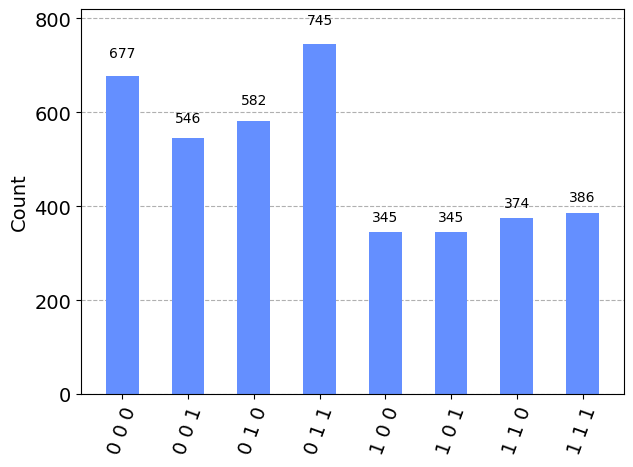

In [42]:
provider = IBMProvider()
backend = provider.get_backend("ibm_kyoto")
transpiled = transpile(circuits=test, backend=backend)
job = backend.run(transpiled)
retrieved_job = provider.backend.retrieve_job(job.job_id())
statistics = retrieved_job.result().get_counts()
display(plot_histogram(statistics))

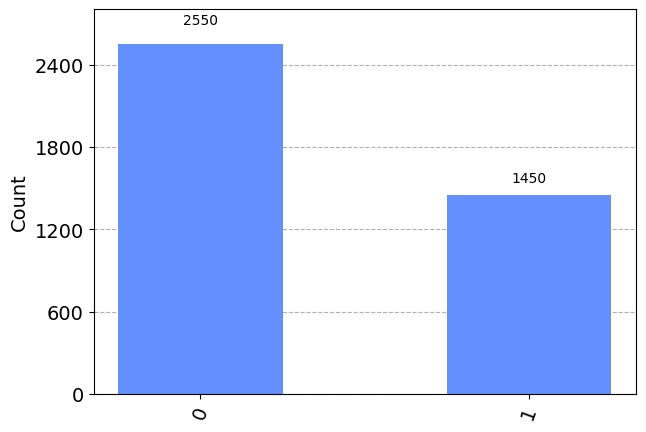

In [43]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

Superdense Coding Protocol

In [44]:
# classical bits to be sent
c = "1"
d = "0"

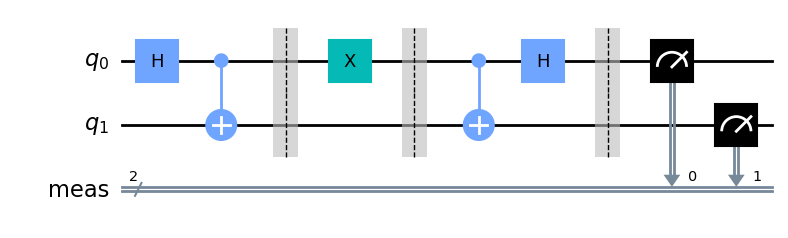

In [45]:
protocol = QuantumCircuit(2)

# prepare the ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw("mpl"))

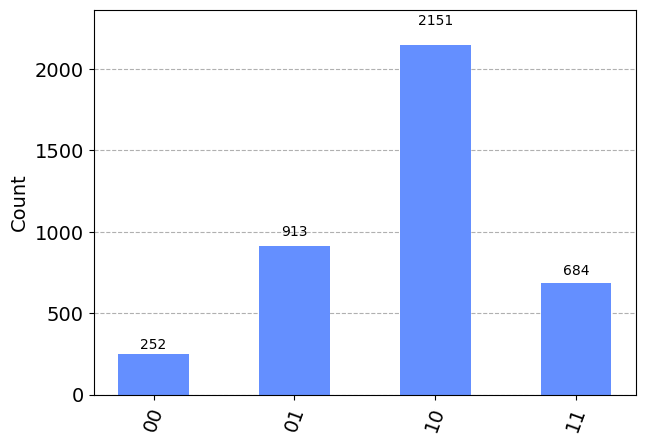

In [46]:
provider = IBMProvider()
backend = provider.get_backend("ibm_kyoto")
transpiled = transpile(protocol, backend=backend)
job = backend.run(transpiled)
retrieved_job = provider.backend.retrieve_job(job.job_id())
statistics = retrieved_job.result().get_counts()
display(plot_histogram(statistics))

CHSH Game

In [55]:
def chsh_game(strategy):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as 'int's) and
            returns two bits (also as 'int's). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss
    """
    # Referee chooses x and y randomly
    x, y = np.random.randint(0, 2), np.random.randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if it is a win or loss
    if (a != b) == (x & y):
        # win
        return 1
    else:
        # loss
        return 0

In [48]:
def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-np.pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-np.pi / 4, 1)
    else:
        qc.ry(np.pi / 4, 1)
    qc.measure(1, 1)

    return qc

(x,y) = (0,0)


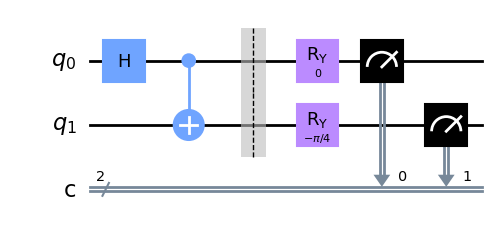

(x,y) = (0,1)


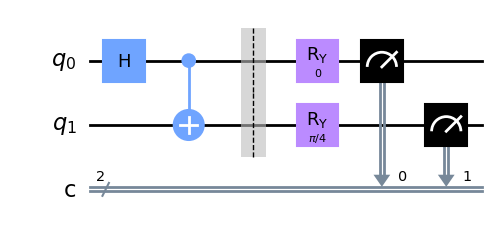

(x,y) = (1,0)


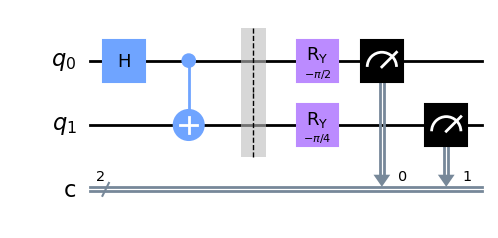

(x,y) = (1,1)


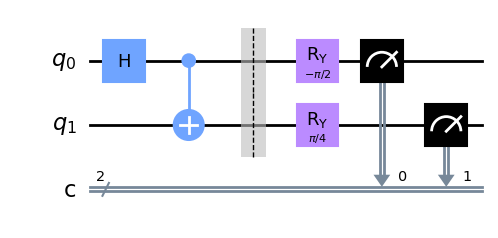

In [50]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw("mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw("mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw("mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw("mpl"))

In [67]:
provider = IBMProvider()
backend = provider.get_backend("ibm_kyoto")

def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    transpiled = transpile(chsh_circuit(x, y), backend=backend)
    job = backend.run(transpiled, shots=1)
    retrieved_job = provider.backend.retrieve_job(job.job_id())
    statistics = retrieved_job.result().get_counts()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

In [53]:
def classical_strategy(x, y):
    """An optimal classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

In [69]:
NUM_GAMES = 30
TOTAL_SCORE_QUANTUM = 0
TOTAL_SCORE_CLASSICAL = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE_QUANTUM += chsh_game(quantum_strategy)
    TOTAL_SCORE_CLASSICAL += chsh_game(classical_strategy)

print("Fraction of games won with quantum strategy:", TOTAL_SCORE_QUANTUM / NUM_GAMES)
print("Fraction of games won with classical strategy:", TOTAL_SCORE_CLASSICAL / NUM_GAMES)

Fraction of games won with quantum strategy: 0.7666666666666667
Fraction of games won with classical strategy: 0.8666666666666667


Low amount of games resulting in lower than expected quantum strategy wins and higher than expected classical strategy wins